In [1]:
import numpy as np
import pandas as pd
import igraph as ig
import cairo
import math

from io import BytesIO
import IPython.display

In [2]:
df = pd.read_csv("data/test.csv")

# convert to strings
df = df.astype(str)
# replace nans with blank string
df = df.applymap(lambda s: "" if s == "nan" else s)
# remove newlines
df = df.applymap(lambda s: s.rstrip('\n'))

# display data
df

,Full Name,Nickname,Father,Mother,Spouse,Children
0,Mother,Mom,Maternal Grandfather,Maternal Grandmother,Father,"Me, Brother, Sister"
1,Father,Dad,Paternal Grandfather,Paternal Grandmother,Mother,"Me, Brother, Sister"
2,Me,,Father,Mother,,
3,Sister,Sis,Father,Mother,,
4,Brother,Bro,Father,Mother,,
5,Paternal Grandfather,PGP,,,Paternal Grandmother,"Father, Ben"
6,Paternal Grandmother,PGM,,,Paternal Grandfather,"Father, Ben"
7,Maternal Grandfather,MGP,,,Maternal Grandmother,"Mother, Sue"
8,Maternal Grandmother,MGM,,,Maternal Grandfather,"Mother, Sue"
9,Ben,,Paternal Grandfather,Paternal Grandmother,,


In [3]:
# number of vertices
V = len(df)
# create index dictionary
di = dict()
for i in range(V):
    di[df["Full Name"][i]] = i
di[""] = -1

def getChildren(v):
    return list(map(lambda s: s.strip(), df.loc[v, "Children"].split(",")))

# create edges
E = [(source, di[dest]) for source in range(V) \
        for dest in list(map(lambda s: s.strip(), df.loc[source, "Children"].split(",")))]

# create graph
G = ig.Graph(directed = True)
G.add_vertices(V)
G.add_edges([e for e in E if e[1] != -1])

# visual styles
vs = {}
vs["vertex_label"] = [df.loc[v, "Nickname"] if df.loc[v, "Nickname"] != "" \
                        else df.loc[v, "Full Name"] for v in range(V)]
vs["layout"] = G.layout("rt")

In [4]:
children = G.degree(mode="out")
parents = G.degree(mode="in")

def height(node):
    if children[node] == 0:
        return -1
    else:
        return max(height(e[1]) for e in E if e[0] == node) + 1
    
def levelHelper(curr, node, level):
    if curr == -1:
        return 0
    
    if curr == node:
        return level
    
    downlevel = 0
    for i in getChildren(curr):
            child = di[i]
            downlevel = levelHelper(child, node, level+1)
            if downlevel != 0:
                return downlevel
    return downlevel
    
def level(node, ref):
    return levelHelper(ref, node, 1)

In [5]:
def topologicalSortUtil(v, visited, stack):
    if v == -1:
        return
    
    # mark node v as visited
    visited[v] = True
    
    # recurse for adjacent nodes
    for name in getChildren(v):
        child = di[name]
        if not visited[child]:
            topologicalSortUtil(child, visited, stack)
    
    # push vertex to stack to store result
    stack.append(v)
    
def topologicalSort():
    visited = [False]*V
    stack = []
    
    for i in range(V):
        if not visited[i]:
            topologicalSortUtil(i, visited, stack)
            
    return stack

In [6]:
def longestPath(v):
    topsort = topologicalSort()
    dist = [-1]*V
    dist[v] = 0
    
    while(len(topsort) != 0):
        u = topsort.pop()
        if dist[u] != -1:
            for name in getChildren(u):
                child = di[name]
                if dist[child] < dist[u] + 1:
                    dist[child] = dist[u] + 1
    return dist

In [7]:
lengths = [max(longestPath(i)) for i in range(V)]
maxlen = max(lengths)

In [8]:
# Returns greatest ancestors along paternal/maternal lines along with distance
def getGreatestAncestors(v):
    paternal = maternal = 0
    p = m = v
    while di[df.loc[p, "Father"]] != -1:
        paternal += 1
        p = di[df.loc[p, "Father"]]
    while di[df.loc[m, "Mother"]] != -1:
        maternal += 1
        m = di[df.loc[m, "Mother"]]
    return {"Paternal": (p, paternal), "Maternal": (m, maternal)}

# Returns furthest ancestor along paternal/maternal lines
def getGreatestAncestor(v):
    ga = getGreatestAncestors(v)
    maxline = max(ga, key=lambda k: ga[k][1])
    return ga[maxline][0]

In [9]:
[getGreatestAncestor(v) for v in range(V)]

[7, 5, 5, 5, 5, 5, 6, 7, 8, 5, 7, 11, 8]

In [10]:
levels = [level(v, getGreatestAncestor(v)) for v in range(V)]
print(levels)

[2, 2, 3, 3, 3, 1, 1, 1, 1, 2, 2, 1, 3]


In [11]:
lengths

[2, 2, 1, 1, 1, 3, 3, 3, 3, 1, 2, 2, 1]

In [12]:
df.loc[:, "Full Name"]

0                   Mother
1                   Father
2                       Me
3                   Sister
4                  Brother
5     Paternal Grandfather
6     Paternal Grandmother
7     Maternal Grandfather
8     Maternal Grandmother
9                      Ben
10                     Sue
11                   Peter
12                  Cousin
Name: Full Name, dtype: object

In [13]:
parents

[2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 0, 2]

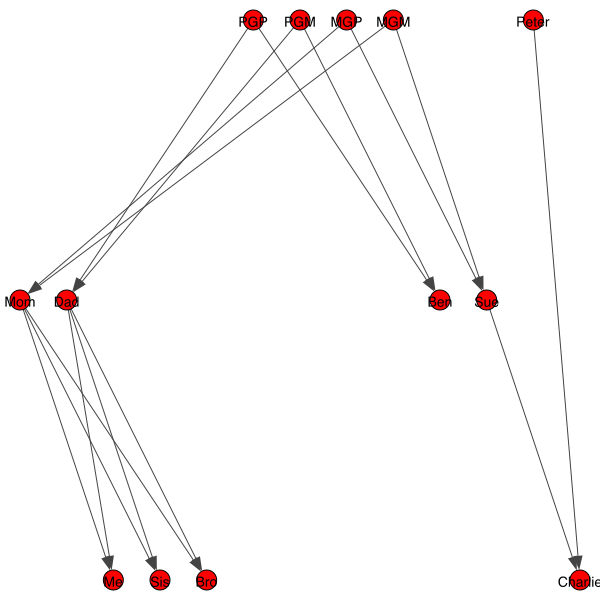

In [14]:
layout = vs["layout"]
vs["layout"] = [[layout[k][0], levels[k]] for k in range(V)]
ig.plot(G, **vs)

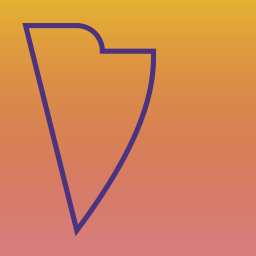

In [15]:
WIDTH, HEIGHT = 256, 256

svgio = BytesIO()
with cairo.SVGSurface(svgio, WIDTH, HEIGHT) as surface:
    ctx = cairo.Context(surface)

    ctx.scale(WIDTH, HEIGHT)  # Normalizing the canvas

    pat = cairo.LinearGradient(0.0, 0.0, 0.0, 1.0)
    pat.add_color_stop_rgba(1, 0.7, 0, 0, 0.5)  # First stop, 50% opacity
    pat.add_color_stop_rgba(0, 0.9, 0.7, 0.2, 1)  # Last stop, 100% opacity

    ctx.rectangle(0, 0, 1, 1)  # Rectangle(x0, y0, x1, y1)
    ctx.set_source(pat)
    ctx.fill()

    ctx.translate(0.1, 0.1)  # Changing the current transformation matrix

    ctx.move_to(0, 0)
    # Arc(cx, cy, radius, start_angle, stop_angle)
    ctx.arc(0.2, 0.1, 0.1, -math.pi / 2, 0)
    ctx.line_to(0.5, 0.1)  # Line to (x,y)
    # Curve(x1, y1, x2, y2, x3, y3)
    ctx.curve_to(0.5, 0.2, 0.5, 0.4, 0.2, 0.8)
    ctx.close_path()

    ctx.set_source_rgb(0.3, 0.2, 0.5)  # Solid color
    ctx.set_line_width(0.02)
    ctx.stroke()
    

IPython.display.SVG(data=svgio.getvalue())